# I have included this code simply because I spent so much time on it. I am still so sad that I didn't ever get it to successfully work how I wanted: (training the backprojection filter with the segmentation unet)

In [1]:
import os
import csv
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow_addons.image import rotate

### Load Data

In [2]:
def normalize_image(in_data):
    out_image = in_data/np.max(in_data)
    return out_image

In [3]:
x_data = list()
unfiltered = list()
y_data = list()
i = 0
flag = False
for file in tqdm(glob.glob(r'D:\BME548Project\Dataset\s_data\big\*.tiff')):
    if not flag:
        im = Image.open(file)
        img = np.asarray(im)
        img = normalize_image(img)
        x_data.append(np.expand_dims(img, axis=2))

        filey = os.path.split(file)[1]
        filey = filey[:-5] + '.png'
        pathy = r'D:\BME548Project\Dataset\y_data\small\y_upload\\'
        full_pathy = os.path.join(pathy, filey)
        im = Image.open(full_pathy)
        img = np.asarray(im)
        y_data.append(np.expand_dims(img, axis=2))
        
        path_ims = r'D:\BME548Project\Dataset\x_data\small\x_upload\\'
        full_pathims = os.path.join(path_ims, filey)
        im = Image.open(full_pathims)
        img = np.asarray(im)
        unfiltered.append(np.expand_dims(img, axis=2))
        
        i += 1
        if i > 500:
            flag = True


x_data = np.array(x_data)
unfiltered = np.array(unfiltered)
y_data = np.array(y_data)

100%|██████████| 3486/3486 [00:02<00:00, 1385.37it/s]


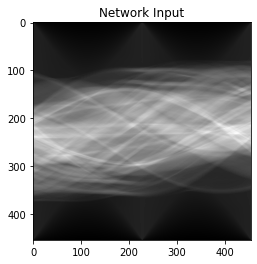

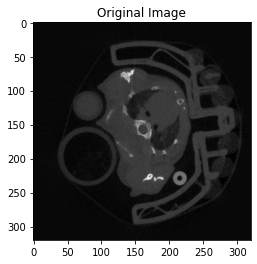

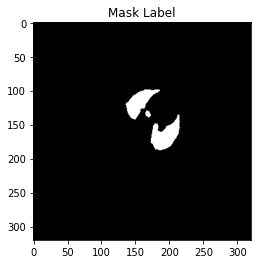

In [4]:
plt.imshow(x_data[0], cmap='gray')
plt.title('Network Input')
plt.show()

plt.imshow(unfiltered[0], cmap='gray')
plt.title('Original Image')
plt.show()

plt.imshow(y_data[0], cmap='gray')
plt.title('Mask Label')
plt.show()

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)

# Using Model.fit()
## (Custom Layer added into a Model)

### Custom Layer

In [5]:
'''
I SPENT HOURS UPON HOURS TRYING TO MAKE IT SO YOU COULD TRAIN THE BACKPROJECTION FILTER.
I NEVER GOT IT TO WORK. I IMAGINE IT HAS SOMETHING TO DO WITH MY ATTEMPT TO IMPLEMENT THE INVERSE RADON TRANSFORM 
IN TENSORFLOW.
'''
class PhysicalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PhysicalLayer, self).__init__()
        
    def build(self, input_size):
        shape = [input_size[1]]
        w_init = tf.random_uniform_initializer(minval=0.49, maxval=.5)
        self.fbp_filter = tf.Variable(w_init(shape=shape), trainable=False)

    def call(self, x_batch):
        def build_batch(in_batch):
            sinogram = tf.cast(in_batch[:, :, 0], tf.complex64)
            pi = 3.14159

            # Filter Sinogram
            projLen, numAngles = sinogram.shape
            filtSinos = tf.TensorArray(dtype=tf.float32, size=numAngles)
            for j in range(numAngles):
                projfft = tf.signal.fftshift(tf.signal.fft(sinogram[:, j]))
                filtProj = projfft * tf.cast(self.fbp_filter, tf.complex64)
                filtSinos = filtSinos.write(j, tf.math.real(tf.signal.ifft(tf.signal.ifftshift(filtProj))))
            filtSino = tf.transpose(filtSinos.stack())
            
            # Backproject:
            imageLen = tf.cast(sinogram.shape[0], tf.float32)
            theta = tf.linspace(0.0, 180.0, 227)
            theta = tf.scalar_mul(pi/180.0, theta)
            numAngles = theta.shape[0]

            recon = tf.zeros((imageLen, imageLen))
            angle = 0.0
            d_angle = tf.cast(pi, tf.float32) / tf.cast(numAngles, tf.float32)
            for n in range(numAngles):
                # Get projection
                s = filtSino[:, 2*n]

                #Create matrix with projection along center axis ready to be rotated:
                zero_layer = tf.zeros(s.shape[0])
                stack = tf.TensorArray(dtype=tf.float32, size=454)
                for k in range(s.shape[0]):
                    stack = stack.write(k, s)
                flat_mat = stack.stack()

                # BackProject/Rotate projection matrix for desired angle:
                rot_mat = rotate(flat_mat, -angle)
                recon = tf.math.add(rot_mat, recon)
                angle += d_angle
                
            # Crop out empty area of image:
            crop = recon[67:387, 67:387]
            out_img = crop[..., tf.newaxis]
            return out_img
        
        def compile_batches(batch_data):
            if batch_data.shape[0] is None:
                size = 1
            else: 
                size = batch_data.shape[0]

            batch_list = tf.TensorArray(dtype=tf.float32, size=size)
            i = 0
            for batch in batch_data:
                batch_image = build_batch(batch)
                batch_list = batch_list.write(i, batch_image)
                i = i + 1
            out_batch_list = batch_list.stack()
            return out_batch_list
        
        return compile_batches(x_batch)

### Simulate Physical Output with Initial Weights

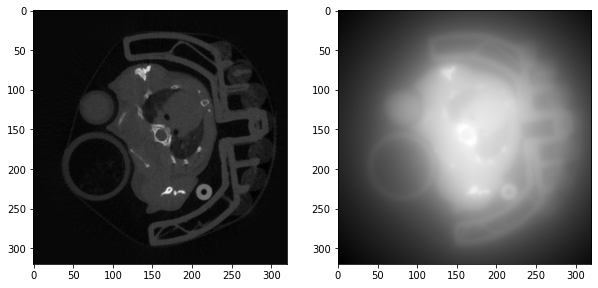

In [20]:
tmp_model = tf.keras.Sequential()
tmp_model.add(PhysicalLayer())
tmp_image = x_data[0]
input_image = tf.constant(tmp_image)[tf.newaxis, ...]
tmp_image = unfiltered[0]

output = tmp_model(input_image).numpy()
out_image = output[0, :, :, 0]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(tmp_image, cmap='gray')
axes[1].imshow(out_image, cmap='gray')
plt.show()

### Unet Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate, Dropout, UpSampling2D
from tensorflow.keras import Model, Input

def my_unet(input_size=(454, 454, 1)):
    kernel_size = 3
    inputs = Input(input_size)
    phys = PhysicalLayer()(inputs)
    conv1 = Conv2D(64, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(phys)
    conv1 = Conv2D(64, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.8)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.8)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

### Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

model_checkpoint = ModelCheckpoint('physical_model.h5', save_best_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
if os.path.isfile('physical_model.h5'):
    model = load_model('physical_model.h5')
    epochs+=5
    initial_e+=5
else:
    print("Define Model")
    model = my_unet()
    print("Initialize Optimizer")
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    print("Compiling")
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[
        'accuracy'])
    epochs=10
    initial_e=0

Define Model


In [ ]:
'''
THIS IS WHERE I WOULD GIVE UP EACH TIME. IT WOULDN'T EVEN GIVE ERRORS. IT WOULD JUST TAKE FOREVER AND NEVER START
SHOWING LOSSES AND ACCURACIES. I EVENTUALLY DECIDED IT WAS NO LONGER WORTH MY TIME.
'''
print("Starting Training")
model.fit(x_train, y_train, initial_epoch=initial_e, epochs=epochs, batch_size=15,
          validation_data=(x_test, y_test))# , callbacks=[model_checkpoint, tensorboard_callback])

### Plotting Examples

In [ ]:
test_image = x_train[10]
input_image = tf.constant(test_image)[tf.newaxis, ...]
trained_filter = model.variables[0].numpy()
out_mask = model(input_image).numpy()
predict_mask = out_mask[0, :, :, 0] 

In [ ]:
def physical_layer_only(xs, filter_weights):  
    @tf.function
    def build_batch(in_batch):
        sinogram = tf.cast(in_batch[:, :, 0], tf.complex64)
        pi = 3.14159

        # Filter Sinogram
        projLen, numAngles = sinogram.shape
        filtSino = list()
        for j in range(numAngles):
            projfft = tf.signal.fftshift(tf.signal.fft(sinogram[:, j]))
            filtProj = projfft * tf.cast(filter_weights, tf.complex64)
            filtSino.append(tf.cast(tf.math.real(tf.signal.ifft(tf.signal.ifftshift(filtProj))), tf.float32))
        filtSino = tf.stack(filtSino, axis=1)
        
        # Backproject:
        imageLen = tf.cast(sinogram.shape[0], tf.float32)
        theta = tf.linspace(0.0, 180.0, 227)
        theta = tf.scalar_mul(pi/180.0, theta)
        numAngles = theta.shape[0]

        recon = tf.zeros((imageLen, imageLen))
        angle = 0.0
        d_angle = tf.cast(pi, tf.float32) / tf.cast(numAngles, tf.float32)
        for n in range(numAngles):
            # Get projection
            s = filtSino[:, 2*n]

            #Create matrix with projection along center axis ready to be rotated:
            projection = list()
            for k in range(s.shape[0]):
                projection.append(s)
            projection = tf.stack(projection, axis=0)
            
            # BackProject/Rotate projection matrix for desired angle:
            projection = rotate(projection, -angle)
            recon = tf.math.add(projection, recon)

            # Crop out empty area of image:
            crop = recon[67:387, 67:387]
            out_img = crop[..., tf.newaxis]
            angle += d_angle
        return out_img

    return build_batch(xs[0])

In [ ]:
out_phys = physical_layer_only(input_image, trained_filter).numpy()
phys_image = out_phys[:, :, 0]
label = y_train[10]

plt.plot(trained_filter)
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(20, 20))
axes[0].imshow(test_image, cmap='gray')
axes[1].imshow(phys_image, cmap='gray')
axes[2].imshow(label, cmap='gray')
axes[3].imshow(predict_mask, cmap='gray')

plt.show()


# I Also Tried Using GradientTape
## (Adding an external layer in front of the model)

### Set Up Dataset

In [6]:
training_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(10)
testing_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(10)

### Unet Model

In [7]:
from keras_unet.models import custom_unet

model = custom_unet(input_shape=(320, 320, 1))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


### Defining My Physical Layer

In [8]:
# Filter Weight Definition:
fbp_filter = np.zeros(454) + .5
fbp_filter = tf.constant(fbp_filter)
fbp_filter = tf.Variable(fbp_filter, trainable=True)

In [9]:
def physical_layer(x_batch):
    def build_batch(in_batch):
        sinogram = tf.cast(in_batch[:, :, 0], tf.complex64)
        pi = 3.14159

        # Filter Sinogram
        projLen, numAngles = sinogram.shape
        filtSinos = tf.TensorArray(dtype=tf.float32, size=numAngles)
        for j in range(numAngles):
            projfft = tf.signal.fftshift(tf.signal.fft(sinogram[:, j]))
            filtProj = projfft * tf.cast(fbp_filter, tf.complex64)
            filtSinos = filtSinos.write(j, tf.math.real(tf.signal.ifft(tf.signal.ifftshift(filtProj))))
        filtSino = tf.transpose(filtSinos.stack())

        # Backproject:
        imageLen = tf.cast(sinogram.shape[0], tf.float32)
        theta = tf.linspace(0.0, 180.0, 454)
        theta = tf.scalar_mul(pi/180.0, theta)
        numAngles = theta.shape[0]

        recon = tf.zeros((imageLen, imageLen))
        angle = 0.0
        d_angle = tf.cast(pi, tf.float32) / tf.cast(numAngles, tf.float32)
        for n in range(numAngles):
            # Get projection
            s = filtSino[:, n]

            #Create matrix with projection along center axis ready to be rotated:
            zero_layer = tf.zeros(s.shape[0])
            stack = tf.TensorArray(dtype=tf.float32, size=454)
            for k in range(s.shape[0]):
                stack = stack.write(k, s)
            flat_mat = stack.stack()

            # BackProject/Rotate projection matrix for desired angle:
            rot_mat = rotate(flat_mat, -angle)
            recon = tf.math.add(rot_mat, recon)
            angle += d_angle
            
        # Crop out empty area of image:
        crop = recon[67:387, 67:387]
        out_img = crop[..., tf.newaxis]
        return out_img

    def compile_batches(batch_data):
        if batch_data.shape[0] is None:
            size = 1
        else: 
            size = batch_data.shape[0]

        batch_list = tf.TensorArray(dtype=tf.float32, size=size)
        i = 0
        for batch in batch_data:
            batch_image = build_batch(batch)
            batch_list = batch_list.write(i, batch_image)
            i = i + 1
        batches_out = batch_list.stack()
        return batches_out

    return compile_batches(x_batch)
    

### Full Forward Model

In [10]:
def forward_model(x_batch):
    pout = physical_layer(x_batch)
    return model(pout)

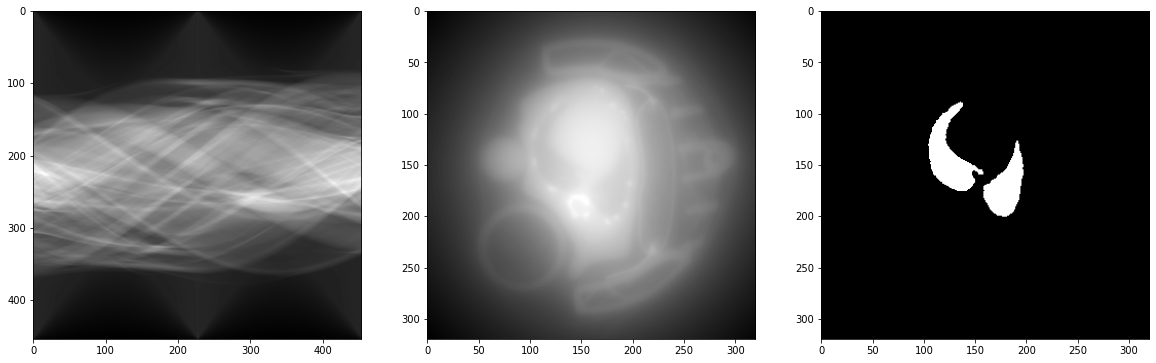

In [11]:
flag = True
for images, labels in training_data:
    if flag:
        in_image = images
        out_image = physical_layer(images)
        label = labels
        flag = False
        break
        
figs, axes = plt.subplots(1, 3, figsize=(20, 20))
        
axes[0].imshow(in_image[0][:, :, 0], cmap='gray')
axes[1].imshow(out_image[0][:, :, 0], cmap='gray')
axes[2].imshow(label[0][:, :, 0], cmap='gray')

plt.show()

### Training Setup

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

train_loss = tf.keras.metrics.BinaryCrossentropy(name='Train Loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='Train Accuracy')

test_loss = tf.keras.metrics.BinaryCrossentropy(name='Test Loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='Test Accuracy')

In [13]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = forward_model(images)
        loss = loss_object(labels, predictions)
    variables_to_monitor = model.trainable_variables
#     variables_to_monitor.append(fbp_filter)
    gradients = tape.gradient(loss, variables_to_monitor)
    optimizer.apply_gradients(zip(gradients, variables_to_monitor))
    train_loss(labels, predictions)
    train_accuracy(labels, predictions)


In [14]:
@tf.function
def test_step(images, labels):
    predictions = forward_model(images)
    test_loss(labels, predictions)
    test_accuracy(labels, predictions)

### Tensorboard Logging

In [15]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

### Load Pretrained Model

In [16]:
# model = tf.saved_model.load('finalproject_model')
# with open('filter.csv', 'r')as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     flag = False
#     for row in csv_reader:
#         if flag is not True:
#             fbp_filter = np.array([float(val) for val in row])
#             flag = True

# fbp_filter = tf.constant(fbp_filter)
# fbp_filter = tf.Variable(fbp_filter, constraint=lambda t: tf.math.real(t))

### Training

In [17]:
starting_epoch = 0
ending_epoch = 5

In [18]:
print(starting_epoch)
print(ending_epoch)

0
5


In [ ]:
for epoch in range(starting_epoch, ending_epoch):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in training_data:
        print('Train step')
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    
    for images, labels in testing_data:
        print('Test step')
        test_step(images, labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
        
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

starting_epoch += 5
ending_epoch += 5

Train step


### Save Model

In [ ]:
tf.saved_model.save(model, 'finalproject_model')
with open('filter.csv', 'w') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',')
    csv_writer.writerow(fbp_filter.numpy().tolist())

### Visualize Optimized Back-Projection Filter

In [ ]:
plt.plot(fbp_filter)
plt.show()

### Plotting Examples

In [ ]:
flag = True
for images, labels in training_data:
    if flag:
        in_image = images
        label = labels
        out_image = physical_layer(images)
        out_mask = forward_model(images)
        flag = False
        break
        
figs, axes = plt.subplots(1, 4, figsize=(20, 20))
        
axes[0].imshow(in_image[0][:, :, 0], cmap='gray')
axes[1].imshow(out_image[0][:, :, 0], cmap='gray')
axes[2].imshow(out_mask[0][:, :, 0], cmap='gray')
axes[3].imshow(label[0][:, :, 0], cmap='gray')

plt.show()

In [57]:
out_im = Image.fromarray(out_image.numpy()[0][:, :, 0])
out_im.save('phys_out.tiff')